---
title: "STAC Tutorial"
description: "Learn how to use the GRASS addon t.stac to search and import STAC API data into a GRASS project."
image: images/stac-to-the-future.png
toc: true
toc-depth: 4
format:
  html:
    code-copy: true
    code-fold: false
    code-tools: true
    mermaid: 
      theme: forest
    other-links:
      - text: grass
        href: https://grass.osgeo.org
      - text: STAC
        href: https://stacspec.org/en
execute:
  enabled: true
  keep-ipynb: true
  eval: false
  freeze: auto
  cache: true
jupyter: python3
author: Corey T. White
date: '2025-03-01'
categories: [stac, grass-addon, tutorial]
page-layout: full
title-block-banner: true
draft: false
---

In this tutorial we will learn about the [t.stac](https://grass.osgeo.org/grass-stable/manuals/addons/t.stac.html) suite of tools for [GRASS](https://grass.osgeo.org).

* [t.stac.catalog](https://grass.osgeo.org/grass-stable/manuals/addons/t.stac.catalog.html) - is a tool for exploring SpatioTemporal Asset Catalogs metadata from a STAC API.
* [t.stac.collection](https://grass.osgeo.org/grass-stable/manuals/addons/t.stac.collection.html) - is a tool for exploring SpatioTemporal Asset Catalog (STAC) collection metadata.
* [t.stac.item](https://grass.osgeo.org/grass-stable/manuals/addons/t.stac.item.html) - is a tool for exploring and importing SpatioTemporal Asset Catalog item metadata and assets into GRASS.

## Introduction

SpatioTemporal Asset Catalog (STAC)...


The tutorial assumes you already have GRASS installed on your machine. If not please [download and install GRASS](https://grass.osgeo.org/download/) before continuing the tutorial.


## Getting Started

### Start GRASS Session

In [1]:
#| label: config-grass
#| eval: true
# Import standard python packages
import sys
import subprocess
from IPython.display import display, JSON, HTML
import json
import pandas as pd
from pathlib import Path
import seaborn as sns
# import polars as pl

# Ask GRASS where its Python packages are and add them to the path
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS python packages we need
import grass.script as gs
import grass.jupyter as gj

Create a GRASS project

In [2]:
#| label: create-project
gs.create_project("stac", epsg="32119", overwrite=True)

and start a GRASS session

In [3]:
#| label: start-grass-session
#| eval: true
session = gj.init("stac")

### Install Addon

The [t.stac](https://grass.osgeo.org/grass-stable/manuals/addons/t.stac.html) addons require the following Python packages.

* [pystac (>=1.12)](https://pystac.readthedocs.io/en/latest/installation.html)
* [pystac_client (>=0.8)](https://pystac-client.readthedocs.io/en/stable/)
* [tqdm (>=4.67)](https://tqdm.github.io/)

You can install them using pip or the Python package manager of your choice. 

```bash
pip install pystac pystac_client tqdm
```

Now you can install the extensions.

In [4]:
#| label: install-t-stac
gs.run_command("g.extension", extension="t.stac")

## Set computational region

In [5]:
#| label: grass-set-region
#| echo: true
#| eval: true
#| include: true
#| output: true
gs.run_command(
    "g.region", n=236687, s=210391, e=616042, w=598921, nsres=10, ewres=10, flags="pa"
)

projection: 99 (NAD83 / North Carolina)
zone:       0
datum:      nad83
ellipsoid:  grs80
north:      236690
south:      210390
west:       598920
east:       616050
nsres:      10
ewres:      10
rows:       2630
cols:       1713
cells:      4505190


In [6]:
#| label: display-interactive-region
#| echo: true
#| eval: true
#| include: true
#| output: true

m = gj.InteractiveMap(use_region=True)
m.save(filename="outputs/basic_map.html")
display(m.show())

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [7]:
m_html = Path("outputs/basic_map.html")
HTML(m_html.read_text())

## STAC API

In [8]:
#| label: set-stac-catalog-url
#| eval: true
stac_url = "https://earth-search.aws.element84.com/v1/"

### Searching STAC Catalogs

::: {.panel-tabset}

## Python

In [9]:
#| label: tbl-stac-catalog
#| echo: true
#| eval: true
#| include: true
#| output: true
catalogs_json = gs.parse_command(
    "t.stac.catalog", url=stac_url, flags="b", format="json"
)
df_catalogs = pd.json_normalize(catalogs_json)
display(df_catalogs.head(10))

,type,id,stac_version,description,links,conformsTo,title
0,Catalog,earth-search-aws,1.1.0,A STAC API of public datasets on AWS,"[{'rel': 'self', 'href': 'https://earth-search...","[https://api.stacspec.org/v1.0.0/core, https:/...",Earth Search by Element 84


## Terminal

In [10]:
#| label: tbl-stac-catalog-shell
#| echo: true
#| eval: true
#| include: true
#| output: true
!t.stac.catalog url={stac_url} format=plain -b

         Please use format=proj4 instead.


         Please use format=proj4 instead.


         Please use format=proj4 instead.
WARNING: Flag 'j' is deprecated and will be removed in a future release.
         Please use format=proj4 instead.


Selected PROJ pipeline:
+proj=pipeline +step +inv +proj=lcc +lat_0=33.75 +lon_0=-79
+lat_1=36.1666666666667 +lat_2=34.3333333333333 +x_0=609601.22 +y_0=0
+no_defs +over +a=6378137 +rf=298.257222101 +towgs84=0.000,0.000,0.000
+step +proj=unitconvert +xy_in=rad +xy_out=deg
************************


---------------------------------------------------------------------------
Catalog: Earth Search by Element 84
---------------------------------------------------------------------------
Client Id: earth-search-aws
Client Description: A STAC API of public datasets on AWS
Client STAC Extensions: []
Client catalog_type: ABSOLUTE_PUBLISHED
---------------------------------------------------------------------------


Collections: 9
---------------------------------------------------------------------------
Collection Id | Collection Title
---------------------------------------------------------------------------
sentinel-2-pre-c1-l2a: Sentinel-2 Pre-Collection 1 Level-2A 
cop-dem-glo-30: Copernicus DEM GLO-30
naip: NAIP: National Agriculture Imagery Program
cop-dem-glo-90: Copernicus DEM GLO-90
landsat-c2-l2: Landsat Collection 2 Level-2
sentinel-2-l2a: Sentinel-2 Level-2A
sentinel-2-l1c: Sentinel-2 Level-1C
sentinel-2-c1-l2a: Sentinel-2 Collection 1 Level-2A
sentinel-1-grd: Sentinel-1 Level-1C Ground Range Detected (GRD)
---------------------------------------------------------------------------


:::

#### Collection Metadata

::: {.panel-tabset}

## Python

In [11]:
#| label: tbl-stac-items
#| echo: true
#| eval: true
#| include: true
#| output: true

items_json = gs.parse_command(
    "t.stac.item",
    url=stac_url,
    collection_id="sentinel-2-l2a",
    flags="m",
    format="json",
)

df_items = pd.json_normalize(items_json, max_level=0)
display(df_items.T.head(5))

,0
type,Collection
id,sentinel-2-l2a
stac_version,1.1.0
description,Global Sentinel-2 data from the Multispectral ...
links,"[{'rel': 'self', 'href': 'https://earth-search..."


## Terminal

In [12]:
#| label: tbl-stac-items-m-shell
#| echo: true
#| eval: true
#| include: true
#| output: true
!t.stac.item url={stac_url} collection_id="sentinel-2-l2a" format=plain -m

         Please use format=proj4 instead.
WARNING: Flag 'j' is deprecated and will be removed in a future release.
         Please use format=proj4 instead.


         Please use format=proj4 instead.


         Please use format=proj4 instead.


Selected PROJ pipeline:
+proj=pipeline +step +inv +proj=lcc +lat_0=33.75 +lon_0=-79
+lat_1=36.1666666666667 +lat_2=34.3333333333333 +x_0=609601.22 +y_0=0
+no_defs +over +a=6378137 +rf=298.257222101 +towgs84=0.000,0.000,0.000
+step +proj=unitconvert +xy_in=rad +xy_out=deg
************************


---------------------------------------------------------------------------

Collection Id: sentinel-2-l2a
Title: Sentinel-2 Level-2A
Description: Global Sentinel-2 data from the Multispectral Instrument (MSI) onboard Sentinel-2
bbox: [[-180, -90, 180, 90]]
Temporal Interval: [['2015-06-27T10:25:31.456000Z', None]]
License: proprietary
Keywords: ['sentinel', 'earth observation', 'esa']
Links: [{'rel': 'self', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a', 'type': 'application/json'}, {'rel': 'cite-as', 'href': 'https://doi.org/10.5270/S2_-742ikth', 'title': 'Copernicus Sentinel-2 MSI Level-2A (L2A) Bottom-of-Atmosphere Radiance'}, {'rel': 'license', 'href': 'https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice', 'title': 'proprietary'}, {'rel': 'parent', 'href': 'https://earth-search.aws.element84.com/v1', 'type': 'application/json'}, {'rel': 'root', 'href': 'https://earth-search.aws.element84.com/v1/', 'type': 'application/json',

:::

#### Query Items by datetime and display table

::: {.panel-tabset}

## Python

In [13]:
#| label: tbl-items
#| tbl-cap: Sentinel 2 Items
#| echo: true
#| eval: true
#| include: true
#| output: true

items_json = gs.parse_command(
    "t.stac.item",
    url=stac_url,
    collection_id="sentinel-2-l2a",
    flags="i",
    datetime="2024-04-01/2024-09-30",
    format="json",
)
num_items = len(df_items)
df_items = pd.json_normalize(items_json, max_level=0)
display(df_items.head(5))

,type,stac_version,stac_extensions,id,geometry,bbox,properties,links,assets,collection
0,Feature,1.1.0,[https://stac-extensions.github.io/processing/...,S2A_17SPV_20240929_0_L2A,"{'type': 'Polygon', 'coordinates': [[[-79.8885...","[-79.9021350633042, 35.13301555004904, -78.668...","{'created': '2024-09-29T23:18:47.401Z', 'platf...","[{'rel': 'self', 'href': 'https://earth-search...",{'aot': {'href': 'https://sentinel-cogs.s3.us-...,sentinel-2-l2a
1,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,S2B_17SPV_20240924_0_L2A,"{'type': 'Polygon', 'coordinates': [[[-79.8885...","[-79.9021350633042, 35.13301555004904, -78.668...","{'created': '2024-09-25T06:45:08.923Z', 'platf...","[{'rel': 'self', 'href': 'https://earth-search...",{'aot': {'href': 'https://sentinel-cogs.s3.us-...,sentinel-2-l2a
2,Feature,1.1.0,[https://stac-extensions.github.io/view/v1.0.0...,S2A_17SPV_20240919_0_L2A,"{'type': 'Polygon', 'coordinates': [[[-79.8885...","[-79.9021350633042, 35.13301555004904, -78.668...","{'created': '2024-09-20T01:57:52.703Z', 'platf...","[{'rel': 'self', 'href': 'https://earth-search...",{'aot': {'href': 'https://sentinel-cogs.s3.us-...,sentinel-2-l2a
3,Feature,1.1.0,[https://stac-extensions.github.io/grid/v1.1.0...,S2B_17SPV_20240914_0_L2A,"{'type': 'Polygon', 'coordinates': [[[-79.8885...","[-79.9021350633042, 35.13301555004904, -78.668...","{'created': '2024-09-15T00:07:17.726Z', 'platf...","[{'rel': 'self', 'href': 'https://earth-search...",{'aot': {'href': 'https://sentinel-cogs.s3.us-...,sentinel-2-l2a
4,Feature,1.1.0,[https://stac-extensions.github.io/grid/v1.1.0...,S2A_17SPV_20240909_0_L2A,"{'type': 'Polygon', 'coordinates': [[[-79.8885...","[-79.9021350633042, 35.13301555004904, -78.668...","{'created': '2024-09-10T01:00:11.150Z', 'platf...","[{'rel': 'self', 'href': 'https://earth-search...",{'aot': {'href': 'https://sentinel-cogs.s3.us-...,sentinel-2-l2a


## Terminal

In [14]:
#| label: tbl-stac-items-i-shell
#| echo: true
#| eval: true
#| include: true
#| output: true
!t.stac.item url={stac_url} collection_id="sentinel-2-l2a" datetime="2024-04-01/2024-09-30" format=plain -i

         Please use format=proj4 instead.


         Please use format=proj4 instead.


         Please use format=proj4 instead.
WARNING: Flag 'j' is deprecated and will be removed in a future release.
         Please use format=proj4 instead.


Selected PROJ pipeline:
+proj=pipeline +step +inv +proj=lcc +lat_0=33.75 +lon_0=-79
+lat_1=36.1666666666667 +lat_2=34.3333333333333 +x_0=609601.22 +y_0=0
+no_defs +over +a=6378137 +rf=298.257222101 +towgs84=0.000,0.000,0.000
+step +proj=unitconvert +xy_in=rad +xy_out=deg
************************


Search Matched: 38 items


bbox: [-79.11829907, 35.64652526, -78.92857699, 35.88363678]
Items Found: 38
Collection ID: sentinel-2-l2a
Item: S2A_17SPV_20240929_0_L2A
Geometry: {'type': 'Polygon', 'coordinates': [[[-79.88850843890832, 36.1397316133374], [-79.9021350633042, 35.14992495410683], [-78.69735281151316, 35.13301555004904], [-78.66879673080497, 36.12219793572046], [-79.88850843890832, 36.1397316133374]]]}
Bbox: [-79.9021350633042, 35.13301555004904, -78.66879673080497, 36.1397316133374]
Datetime: 2024-09-29 16:13:28.352000+00:00
Start Datetime not found.
End Datetime not found.
Extra Fields:
---------------------------------------------------------------------------
Extensions:
---------------------------------------------------------------------------
	https://stac-extensions.github.io/processing/v1.1.0/schema.json
	https://stac-extensions.github.io/projection/v2.0.0/schema.json
	https://stac-extensions.github.io/raster/v1.1.0/schema.json
	https://stac-extensions.github.io/mgrs/v1.0.0/schema.json
	https:

Start Datetime not found.
End Datetime not found.
Extra Fields:
---------------------------------------------------------------------------
Extensions:
---------------------------------------------------------------------------
	https://stac-extensions.github.io/view/v1.0.0/schema.json
	https://stac-extensions.github.io/processing/v1.1.0/schema.json
	https://stac-extensions.github.io/mgrs/v1.0.0/schema.json
	https://stac-extensions.github.io/eo/v1.1.0/schema.json
	https://stac-extensions.github.io/grid/v1.1.0/schema.json
	https://stac-extensions.github.io/raster/v1.1.0/schema.json
	https://stac-extensions.github.io/projection/v2.0.0/schema.json
---------------------------------------------------------------------------
Properties:
#     created: 2024-09-20T01:57:52.703Z
#     platform: sentinel-2a
#     constellation: sentinel-2
---------------------------------------------------------------------------
    instruments:
#     eo:cloud_cover: 72.722346
#     mgrs:utm_zone: 17
#     mgrs

Start Datetime not found.
End Datetime not found.
Extra Fields:
---------------------------------------------------------------------------
Extensions:
---------------------------------------------------------------------------
	https://stac-extensions.github.io/view/v1.0.0/schema.json
	https://stac-extensions.github.io/raster/v1.1.0/schema.json
	https://stac-extensions.github.io/grid/v1.1.0/schema.json
	https://stac-extensions.github.io/eo/v1.1.0/schema.json
	https://stac-extensions.github.io/projection/v2.0.0/schema.json
	https://stac-extensions.github.io/processing/v1.1.0/schema.json
	https://stac-extensions.github.io/mgrs/v1.0.0/schema.json
---------------------------------------------------------------------------
Properties:
#     created: 2024-07-12T01:47:22.047Z
#     platform: sentinel-2a
#     constellation: sentinel-2
---------------------------------------------------------------------------
    instruments:
#     eo:cloud_cover: 72.374904
#     mgrs:utm_zone: 17
#     mgrs

Extra Fields:
---------------------------------------------------------------------------
Extensions:
---------------------------------------------------------------------------
	https://stac-extensions.github.io/raster/v1.1.0/schema.json
	https://stac-extensions.github.io/eo/v1.1.0/schema.json
	https://stac-extensions.github.io/mgrs/v1.0.0/schema.json
	https://stac-extensions.github.io/grid/v1.1.0/schema.json
	https://stac-extensions.github.io/view/v1.0.0/schema.json
	https://stac-extensions.github.io/projection/v2.0.0/schema.json
	https://stac-extensions.github.io/processing/v1.1.0/schema.json
---------------------------------------------------------------------------
Properties:
#     created: 2024-05-08T10:59:32.738Z
#     platform: sentinel-2b
#     constellation: sentinel-2
---------------------------------------------------------------------------
    instruments:
#     eo:cloud_cover: 40.339398
#     mgrs:utm_zone: 17
#     mgrs:latitude_band: S
#     mgrs:grid_square: PV
#    

:::

In [15]:
# | echo: false
# | eval: true
# | include: true
# | output: true

num_items = len(df_items)
# Can't use inline python with using Jupyter cache
print(f"There are {num_items} Sentinel 2 items found in our computational region.")

There are 38 Sentinel 2 items found in our computational region.


Let's look closer at the properties of item id `S2A_17SPV_20240919_0_L2A`.

In [16]:
# | echo: true
# | eval: true
# | include: true
# | output: true

df_item = df_items.query("id == 'S2A_17SPV_20240919_0_L2A'")
df_properties = df_item["properties"].apply(pd.Series)
df_item = pd.concat([df_item, df_properties], axis=1)
df_item = df_item.drop("properties", axis=1)
display(df_item.T)

,2
type,Feature
stac_version,1.1.0
stac_extensions,[https://stac-extensions.github.io/view/v1.0.0...
id,S2A_17SPV_20240919_0_L2A
geometry,"{'type': 'Polygon', 'coordinates': [[[-79.8885..."
bbox,"[-79.9021350633042, 35.13301555004904, -78.668..."
links,"[{'rel': 'self', 'href': 'https://earth-search..."
assets,{'aot': {'href': 'https://sentinel-cogs.s3.us-...
collection,sentinel-2-l2a
created,2024-09-20T01:57:52.703Z


Let's look at the items properties

In [17]:
# | echo: true
# | eval: true
# | include: true
# | output: true
df_item = df_items.query("id == 'S2A_17SPV_20240919_0_L2A'")
df_properties = df_item["properties"].apply(pd.Series)
display(df_properties.T)

,2
created,2024-09-20T01:57:52.703Z
platform,sentinel-2a
constellation,sentinel-2
instruments,[msi]
eo:cloud_cover,72.722346
mgrs:utm_zone,17
mgrs:latitude_band,S
mgrs:grid_square,PV
grid:code,MGRS-17SPV
view:sun_azimuth,155.767672


Now we let's look at the items assets.

In [18]:
# | echo: true
# | eval: true
# | include: true
# | output: true
df_item = df_items.query("id == 'S2A_17SPV_20240919_0_L2A'")
df_assets = df_item["assets"].apply(pd.Series)
display(df_assets.T.reset_index())

,index,2
0,aot,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
1,blue,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
2,coastal,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
3,granule_metadata,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
4,green,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
5,nir,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
6,nir08,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
7,nir09,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
8,red,{'href': 'https://sentinel-cogs.s3.us-west-2.a...
9,rededge1,{'href': 'https://sentinel-cogs.s3.us-west-2.a...


#### Assets

In [19]:
#| label: tbl-items-assets
#| tbl-cap: Sentinel 2 Items Assets Metadata
#| echo: true
#| eval: true
#| include: true
#| output: true

stac_query = {"eo:cloud_cover": {"lt": 10}}

assets_json = gs.parse_command(
    "t.stac.item",
    url=stac_url,
    collection_id="sentinel-2-l2a",
    flags="a",
    datetime="2024-04-01/2024-09-30",
    asset_keys="red,nir",
    query=json.dumps(stac_query),
    format="json",
)

df_items_assets = pd.json_normalize(assets_json, max_level=0)
display(df_items_assets.head(10))

,href,type,title,eo:bands,gsd,proj:shape,proj:transform,raster:bands,roles,collection_id,item_id,file_name,datetime
0,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,NIR 1 (band 8) - 10m,"[{'name': 'nir', 'common_name': 'nir', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240909_0_L2A,sentinel-2-l2a.S2A_17SPV_20240909_0_L2A.nir,2024-09-09T16:13:25.358000Z
1,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,Red (band 4) - 10m,"[{'name': 'red', 'common_name': 'red', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240909_0_L2A,sentinel-2-l2a.S2A_17SPV_20240909_0_L2A.red,2024-09-09T16:13:25.358000Z
2,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,NIR 1 (band 8) - 10m,"[{'name': 'nir', 'common_name': 'nir', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2B_17SPV_20240825_0_L2A,sentinel-2-l2a.S2B_17SPV_20240825_0_L2A.nir,2024-08-25T16:13:26.986000Z
3,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,Red (band 4) - 10m,"[{'name': 'red', 'common_name': 'red', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2B_17SPV_20240825_0_L2A,sentinel-2-l2a.S2B_17SPV_20240825_0_L2A.red,2024-08-25T16:13:26.986000Z
4,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,NIR 1 (band 8) - 10m,"[{'name': 'nir', 'common_name': 'nir', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240731_0_L2A,sentinel-2-l2a.S2A_17SPV_20240731_0_L2A.nir,2024-07-31T16:13:28.790000Z
5,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,Red (band 4) - 10m,"[{'name': 'red', 'common_name': 'red', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240731_0_L2A,sentinel-2-l2a.S2A_17SPV_20240731_0_L2A.red,2024-07-31T16:13:28.790000Z
6,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,NIR 1 (band 8) - 10m,"[{'name': 'nir', 'common_name': 'nir', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240611_0_L2A,sentinel-2-l2a.S2A_17SPV_20240611_0_L2A.nir,2024-06-11T16:13:32.315000Z
7,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,Red (band 4) - 10m,"[{'name': 'red', 'common_name': 'red', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240611_0_L2A,sentinel-2-l2a.S2A_17SPV_20240611_0_L2A.red,2024-06-11T16:13:32.315000Z
8,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,NIR 1 (band 8) - 10m,"[{'name': 'nir', 'common_name': 'nir', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240522_0_L2A,sentinel-2-l2a.S2A_17SPV_20240522_0_L2A.nir,2024-05-22T16:13:25.575000Z
9,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,Red (band 4) - 10m,"[{'name': 'red', 'common_n

In [20]:
display(assets_json)

In [21]:
# | echo: false
# | eval: true
# | include: true
# | output: true

num_assets = len(assets_json)
# Can't use inline python with using Jupyter cache
print(f"There are {num_assets} Sentinel 2 assets found in our computational region.")

There are 14 Sentinel 2 assets found in our computational region.


#### EO Parameters

### Create Metadata Vector

In [22]:
#| label: assets-metadata-vector
#| tbl-cap: Sentinel 2 Items Assets Metadata
#| echo: true
#| eval: true
#| include: true
#| output: true

stac_query = {"eo:cloud_cover": {"lt": 10}}

assets_json = gs.parse_command(
    "t.stac.item",
    url=stac_url,
    collection_id="sentinel-2-l2a",
    flags="a",
    datetime="2024-04-01/2024-09-30",
    asset_keys="red,nir",
    query=json.dumps(stac_query),
    items_vector="sentinel_2_items",
    format="json",
)


df_items_assets = pd.json_normalize(assets_json, max_level=0)
display(df_items_assets.head(5))

,href,type,title,eo:bands,gsd,proj:shape,proj:transform,raster:bands,roles,collection_id,item_id,file_name,datetime
0,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,NIR 1 (band 8) - 10m,"[{'name': 'nir', 'common_name': 'nir', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240909_0_L2A,sentinel-2-l2a.S2A_17SPV_20240909_0_L2A.nir,2024-09-09T16:13:25.358000Z
1,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,Red (band 4) - 10m,"[{'name': 'red', 'common_name': 'red', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240909_0_L2A,sentinel-2-l2a.S2A_17SPV_20240909_0_L2A.red,2024-09-09T16:13:25.358000Z
2,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,NIR 1 (band 8) - 10m,"[{'name': 'nir', 'common_name': 'nir', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2B_17SPV_20240825_0_L2A,sentinel-2-l2a.S2B_17SPV_20240825_0_L2A.nir,2024-08-25T16:13:26.986000Z
3,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,Red (band 4) - 10m,"[{'name': 'red', 'common_name': 'red', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2B_17SPV_20240825_0_L2A,sentinel-2-l2a.S2B_17SPV_20240825_0_L2A.red,2024-08-25T16:13:26.986000Z
4,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,image/tiff; application=geotiff; profile=cloud...,NIR 1 (band 8) - 10m,"[{'name': 'nir', 'common_name': 'nir', 'descri...",10,"[10980, 10980]","[10, 0, 600000, 0, -10, 4000020]","[{'nodata': 0, 'data_type': 'uint16', 'bits_pe...","[data, reflectance]",sentinel-2-l2a,S2A_17SPV_20240731_0_L2A,sentinel-2-l2a.S2A_17SPV_20240731_0_L2A.nir,2024-07-31T16:13:28.790000Z


#### View the items with iPyleaflet

In [23]:
# | echo: true
# | eval: true
# | include: true
# | output: true
import random

m = gj.InteractiveMap(use_region=False)
m.add_vector(
    "sentinel_2_items",
    style={"opacity": 1, "dashArray": "9", "fillOpacity": 0.1, "weight": 1},
    hover_style={"color": "white", "dashArray": "0", "fillOpacity": 0.5},
    style_callback=lambda f: {
        "color": "black",
        "fillColor": random.choice(["red", "yellow", "green", "orange"]),
    }
)
display(m.show())

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

### Download and Import Rasters

### Register STRDS

::: {.panel-tabset}

## Python

In [24]:
#| label: tbl-collection-items-assets
#| tbl-cap: Sentinel 2 Items Assets Metadata
#| echo: true
#| eval: true
#| include: true
#| output: true

import grass.script as gs
import grass.jupyter as gj
stac_query = {"eo:cloud_cover": {"lt": 10}}

items_assets_json = gs.parse_command(
    "t.stac.item",
    url=stac_url,
    collection_id="sentinel-2-l2a",
    datetime="2024-04-01/2024-09-30",
    asset_keys="red,nir",
    format="json",
    query=json.dumps(stac_query)
)

## Terminal

In [25]:
#| label: tbl-collection-items-assets-terminal
#| tbl-cap: Sentinel 2 Items Assets Metadata
#| echo: true
#| eval: true
#| include: true
#| output: true
!t.stac.item url="https://earth-search.aws.element84.com/v1/" collection_id="sentinel-2-l2a" datetime="2024-04-01/2024-09-30" asset_keys="red,nir" format="json" query='{"eo:cloud_cover": {"lt": 10}}'

         Please use format=proj4 instead.
WARNING: Flag 'j' is deprecated and will be removed in a future release.
         Please use format=proj4 instead.


         Please use format=proj4 instead.
WARNING: Flag 'j' is deprecated and will be removed in a future release.
         Please use format=proj4 instead.


Selected PROJ pipeline:
+proj=pipeline +step +inv +proj=lcc +lat_0=33.75 +lon_0=-79
+lat_1=36.1666666666667 +lat_2=34.3333333333333 +x_0=609601.22 +y_0=0
+no_defs +over +a=6378137 +rf=298.257222101 +towgs84=0.000,0.000,0.000
+step +proj=unitconvert +xy_in=rad +xy_out=deg
************************


Search Matched: 7 items


{"count": 14, "bytes": 3303941772}


:::

In [26]:
#| label: download-estimate
#| echo: true
#| eval: true
#| include: true
#| output: true

print(f"""
Download Estimate
 
Files:  {items_assets_json["count"]}
Total Download Size: {items_assets_json["bytes"] ** 1e-9:.2f} GB
""")


Download Estimate

Files:  14
Total Download Size: 1.00 GB



In [27]:
#| label: tbl-collection-items-assets-strds
#| tbl-cap: Sentinel 2 Items Assets Metadata
#| echo: true
#| eval: false
#| include: true
#| output: true
stac_query = {"eo:cloud_cover": {"lt": 10}}

collection_items_assets_json = gs.parse_command(
    "t.stac.item",
    url=stac_url,
    collection_id="sentinel-2-l2a",
    datetime="2024-04-01/2024-09-30",
    asset_keys="red,nir",
    query=json.dumps(stac_query),
    strds_output="outputs/s2_red.txt",
    format="json"
)

In [28]:
print(Path("outputs/s2_red.txt").read_text())

In [29]:
startdate = df_items_assets["datetime"].min()
enddate = df_items_assets["datetime"].max()
print(f"Start Date: {startdate}\nEnd Date: {enddate}")

Create STRDS

In [30]:
#| label: create-strds
#| echo: true
#| eval: true
#| include: true
#| output: true

# Create the space time dataset
gs.run_command(
    "t.create",
    output="sentinel_2_red_nir",
    type="strds",
    temporaltype="absolute",
    title="Sentinel 2 Red/NIR Bands",
    description="Sentinel 2 Red/NIR Bands from 2024-04-01/2024-09-30",
    overwrite=True,
)

Download the data

In [31]:
#| label: download-assets
#| echo: true
#| eval: false
#| include: true
#| output: true
print(gs.run_command(
    "t.stac.item",
    url=stac_url,
    collection_id="sentinel-2-l2a",
    datetime="2024-04-01/2024-09-30",
    asset_keys="red,nir",
    query=json.dumps(stac_query),
    strds_output="outputs/s2_red_nir.txt",
    format="json",
    method="nearest",
    resolution="value",
    resolution_value="10",
    extent="region",
    nprocs=7,
    memory=1024 * 7,
    flags="d",
))

Register the data

In [32]:
#| label: register-strds
#| echo: true
#| eval: false
#| include: true
#| output: true

# Register the output maps into a space time dataset
gs.run_command(
    "t.register",
    input="sentinel_2_red_nir",
    file="outputs/s2_red_nir.txt",
    type="raster",
    unit="days"
)

In [33]:
gs.run_command("t.info", type="strds", input="sentinel_2_red_nir")

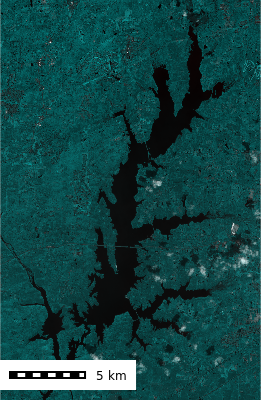

None

In [34]:
#| label: display-composite
#| echo: true
#| eval: true
#| include: true
#| output: true

m = gj.Map(use_region=True)
m.d_rgb(
    red="sentinel-2-l2a.S2A_17SPV_20240909_0_L2A.red",
    blue="sentinel-2-l2a.S2A_17SPV_20240909_0_L2A.nir",
    green="sentinel-2-l2a.S2A_17SPV_20240909_0_L2A.nir",
)
m.d_barscale()
display(m.show())

In [35]:
#| label: display-time-series
#| echo: true
#| eval: true
#| include: true
#| output: true

# Create Time Series Map
# m = gj.TimeSeriesMap(use_region=True)
# m.add_raster_series("sentinel_2_red_nir", fill_gaps=False)
# m.d_barscale()
# m.render()
# display(m.show())

In [36]:
strds_df = pd.DataFrame(
    gs.parse_command(
        "t.rast.list",
        input="sentinel_2_red_nir",
        order="start_time",
        columns=["name", "semantic_label", "start_time", "end_time", "min", "max"],
        format="csv",
    )
)

# Convert start_time to datetime for better formatting
strds_df["start_time"] = pd.to_datetime(strds_df["start_time"])

sns.lineplot(
    x="start_time", y="max", hue="semantic_label", style="semantic_label", data=strds_df
)

# Format x-axis labels for better readability
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels

In [37]:
gs.run_command(
    "t.rast.mapcalc",
    inputs=["sentinel_2_red_nir.nir", "sentinel_2_red_nir.red"],
    output="ndvi",
    basename="ndvi",
    method="follows",
    expression="float('sentinel_2_red_nir.red' - 'sentinel_2_red_nir.nir') / ('sentinel_2_red_nir.red' + 'sentinel_2_red_nir.nir')",
    overwrite=True,
    flags="n"
)

In [38]:
gs.run_command("t.list", type="strds")

In [39]:
# | layout-ncol: 3
ndvi_list = gs.parse_command(
    "t.rast.list",
    input="ndvi",
    order="start_time",
    columns=["name", "semantic_label", "start_time", "end_time", "min", "max"],
    format="csv",
)
gs.run_command("t.rast.colors", input="ndvi", color="ndvi")

for ndvi in ndvi_list:
    map_name = ndvi.get("name")
    m = gj.Map(use_region=True, width=500)
    m.d_rast(map=map_name)
    m.d_barscale()
    m.d_legend(raster=map_name, flags="b")
    display(m.show())

## References

- [pystac Documentation](https://pystac.readthedocs.io/)
- [pystac_client Documentation](https://pystac-client.readthedocs.io/)